# Building a Basic CNN: The MNIST Dataset

In this notebook, we will build a simple CNN-based architecture to classify the 10 digits (0-9) of the MNIST dataset. The objective of this notebook is to become familiar with the process of building CNNs in TensorFlow.

We will go through the following steps:
1. Importing libraries and the dataset
2. Data preparation: Train-test split, specifying the shape of the input data etc.
3. Building and understanding the CNN architecture 
4. Fitting and evaluating the model

Let's dive in.

## 1. Importing Libraries and the Dataset

Let's load the required libraries. From Keras, we need to import two main components:
1. `Sequential` from `tensrflow.keras.models`: `Sequential` is the keras abstraction for creating models with a stack of layers (MLP has multiple hidden layers, CNNs have convolutional layers, etc.). 
2. Various types of layers from `tensrflow.keras.layers`: These layers are added (one after the other) to the `Sequential` model


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# importing the required libraries
import tensorflow as tf

# importing different elements (datasets, layers, etc.) to build the CNN model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D , Dropout, MaxPooling2D

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

Let's load the MNIST dataset from `tensrflow.keras.datasets`. The download may take a few minutes.

In [2]:
# load the dataset into train and test sets
mnist = tf.keras.datasets.mnist
 
(train_images,train_labels),(test_images, test_labels)=mnist.load_data()

# Defining the class names
class_names = ['0','1','2','3','4','5','6','7','8','9']

11490434/11490434 [==============================] - 6s 1us/step


In [3]:
# Explore the training data as follows:
print(train_images.shape)
print(len(train_labels))

(60000, 28, 28)
60000


In [4]:
# Explore the test data as follows:
print(test_images.shape)
print(len(test_labels))

(10000, 28, 28)
10000


So we have 60,000 training and 10,000 test images each of size 28 x 28. Note that the images are grayscale and thus are stored as 2D arrays.<br> 

## 2. Data Preparation

Let's prepare the dataset for feeding to the network. We will do the following three main steps:<br>

#### 2.1 Reshape the Data
First, let's understand the shape in which the network expects the training data. 
Since we have 20,000 training samples each of size (28, 28, 1), the training data (`train_images`) needs to be of the shape `(20000, 28, 28, 1)`. If the images were coloured, the shape would have been `(20000, 28, 28, 3)`.

Same goes for the `test_images`.

#### 2.2 Rescaling (Normalisation)
The value of each pixel is between 0-255, so we will **rescale each pixel** by dividing by 255 so that the range becomes 0-1. Recollect <a href="https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn">why normalisation is important for training NNs</a>.

In [5]:
# reshape x_train and x_test
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# normalisation
train_images = train_images / 255.0
test_images = test_images / 255.0

## 3. Building the Model

Let's now build the CNN architecture. For the MNIST dataset, we do not need to build a very sophisticated CNN - a simple shallow-ish CNN would suffice. 

We will build a network with:
- two convolutional layers having 32 and 64 filters respectively, 
- followed by a max pooling layer, 
- and then `Flatten` the output of the pooling layer to give us a long vector, 
- then add a fully connected `Dense` layer with 128 neurons, and finally
- add a `softmax` layer with 10 neurons

The generic way to build a model in Keras is to instantiate a `Sequential` model and keep adding `tensorflow.keras.layers` to it. We will also use some dropouts.

In [7]:
# model
model = models.Sequential()

# Convolution and Pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flattening and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Adding the output layer
model.add(layers.Dense(10, activation='softmax'))

# Model summary
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-10-01 15:57:25.759371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-01 15:57:25.759745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

#### Understanding Model Summary

It is a good practice to spend some time staring at the model summary above and verify the number of parameteres, output sizes etc. Let's do some calculations to verify that we understand the model deeply enough. 

- Layer-1 (Conv2D): We have used 32 kernels of size (3, 3), and each kernel has a single bias, so we have 32 x 3 x 3 (weights) + 32 (biases) = 320 parameters (all trainable). Note that the kernels have only one channel since the input images are 2D (grayscale). By default, a convolutional layer uses stride of 1 and no padding, so the output from this layer is of shape 26 x 26 x 32, as shown in the summary above (the first element `None` is for the batch size).

- Layer-2 (Conv2D): We have used 64 kernels of size (3, 3), but this time, each kernel has to convolve a tensor of size (26, 26, 32) from the previous layer. Thus, the kernels will also have 32 channels, and so the shape of each kernel is (3, 3, 32) (and we have 64 of them). So we have 64 x 3 x 3 x 32 (weights) + 64 (biases) = 18496 parameters (all trainable). The output shape is (24, 24, 64) since each kernel produces a (24, 24) feature map.

- Max pooling: The pooling layer gets the (24, 24, 64) input from the previous conv layer and produces a (12, 12, 64) output (the default pooling uses stride of 2). There are no trainable parameters in the pooling layer.

- The `Dropout` layer does not alter the output shape and has no trainable parameters.

- The `Flatten` layer simply takes in the (12, 12, 64) output from the previous layer and 'flattens' it into a vector of length 12 x 12 x 64 = 9216.

- The `Dense` layer is a plain fully connected layer with 128 neurons. It takes the 9216-dimensional output vector from the previous layer (layer l-1) as the input and has 128 x 9216 (weights) + 128 (biases) =  1179776 trainable parameters. The output of this layer is a 128-dimensional vector.

- The `Dropout` layer simply drops a few neurons.

- Finally, we have a `Dense` softmax layer with 10 neurons which takes the 128-dimensional vector from the previous layer as input. It has 128 x 10 (weights) + 10 (biases) = 1290 trainable parameters.

Thus, the total number of parameters are 1,199,882 all of which are trainable.

## 4. Fitting and Evaluating the Model

Let's now compile and train the model.

In [8]:
# Defining the model parameters
# optimizer: adam (SGD)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fitting the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10


2022-10-01 15:57:26.392552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 15:57:26.684202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9588

2022-10-01 15:57:43.619317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 8ms/step - loss: 0.1330 - accuracy: 0.9588 - val_loss: 0.0508 - val_accuracy: 0.9837
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0489 - accuracy: 0.9846 - val_loss: 0.0365 - val_accuracy: 0.9876
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 0.0308 - val_accuracy: 0.9889
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0338 - val_accuracy: 0.9886
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0203 - accuracy: 0.9929 - val_loss: 0.0289 - val_accuracy: 0.9909
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0282 - val_accuracy: 0.9913
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0387 - val_accuracy: 0.9

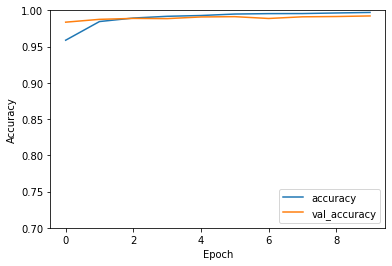

In [9]:
# Plotting accuracy over train and test data against the Epoch value
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

In [10]:
# Evaluating the test accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - loss: 0.0288 - accuracy: 0.9923 - 1s/epoch - 4ms/step
0.9923000335693359


The final loss (on test data) is about 0.04 and the accuracy is 99.1%.